In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as mcm
import matplotlib.gridspec as gridspec
from matplotlib.ticker import PercentFormatter
from matplotlib.colors import LogNorm
from epiweeks import Week
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd
from scipy.stats import gaussian_kde

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Figure 3: Destination region of introductions into San Diego is dependent on lineage origin.
We plot the proportion of Markov jumps from Baja California that end up in each of San Diego's Health and Human Services Agency (HHSA) region to determine how human mobility affects connectivity. We compare this against the proportion of jumps from all other locations as a null hypothesis.

Import the jumps from the discrete state analysis. This table is generated by running the `TreeMarkovJumpHistoryAnalyzer` on the posterior distribution of trees from the discrete-state reconstruction performed with BEAST.

In [2]:
jumps = pd.read_csv( "../data/2022-11-17_exponential_fixed_discete_HHSA.Location.csv.gz")
jumps["date"] = jumps["time"].apply( dec_to_date )
jumps["date"] = jumps["date"].dt.normalize()
jumps.head()

,treeId,startLocation,endLocation,time,date
0,100000,Los Angeles,Rest of World,2021.755067,2021-10-03
1,100000,Los Angeles,Rest of World,2021.679527,2021-09-06
2,100000,Los Angeles,Rest of World,2022.009076,2022-01-04
3,100000,Los Angeles,Rest of World,2022.173689,2022-03-05
4,100000,Los Angeles,Rest of World,2022.022639,2022-01-09


We calculate the percentage of jumps that are estimated to transitions from Baja California to San Diego that land in each of San Diego's 6 HHSA regions for each tree in the posterior. We calculate the same for jumps that are estimated to transition from all other locations into San Diego.

In [3]:
# Baja California
jbc = jumps.loc[(jumps["startLocation"]=="Baja California")&(jumps["endLocation"].str.startswith( "San Diego"))]
plot_bc = jbc.pivot_table( index="treeId", columns="endLocation", values="time", aggfunc="count", fill_value=0 )
plot_bc = plot_bc.apply( lambda x: x/x.sum(), axis=1 )
plot_bc = plot_bc.agg( ["median", lambda x: x.quantile( 0.025 ), lambda x: x.quantile( 0.975)] ).T
plot_bc.columns = ["median", "quantile5", "quantil95"]

# All other locations
jrest = jumps.loc[(jumps["startLocation"]!="Baja California")&(jumps["endLocation"].str.startswith( "San Diego"))]
plot_rest = jrest.pivot_table( index="treeId", columns="endLocation", values="time", aggfunc="count", fill_value=0 )
plot_rest = plot_rest.apply( lambda x: x/x.sum(), axis=1 )
plot_rest = plot_rest.agg( ["median", lambda x: x.quantile( 0.025 ), lambda x: x.quantile( 0.975)] ).T
plot_rest.columns = ["median", "quantile5", "quantil95"]

# Combine the two locations while renaming the columns to reflect the source
plot_df = plot_rest.merge( plot_bc, left_index=True, right_index=True, suffixes=("_rest", "_bc") )
plot_df["diff"] = plot_df["median_bc"] - plot_df["median_rest"]
plot_df = plot_df.sort_values( "diff" ).reset_index()
plot_df

,endLocation,median_rest,quantile5_rest,quantil95_rest,median_bc,quantile5_bc,quantil95_bc,diff
0,San Diego-North Inland,0.123596,0.115385,0.132558,0.000000,0.000000,0.000000,-0.123596
1,San Diego-North Central,0.242991,0.223005,0.263789,0.150943,0.000000,0.259259,-0.092047
2,San Diego-North Coastal,0.078522,0.072848,0.084577,0.000000,0.000000,0.015385,-0.078522
3,San Diego-East,0.212411,0.196759,0.230248,0.223881,0.125000,0.348837,0.011470
4,San Diego-Central,0.158986,0.142857,0.176887,0.279070,0.166667,0.400000,0.120084
5,San Diego-South,0.182418,0.165888,0.198614,0.358491,0.253968,0.520833,0.176073


We also calculate for each HHSA region, the percentage of tree in which their are proportionally more jumps from Baja California than jumps from all other locations.

In [4]:
jumps_collapse = jumps.copy()
jumps_sd = jumps_collapse.loc[jumps_collapse["endLocation"].str.startswith( "San Diego")]
jumps_sd.loc[jumps_sd["startLocation"]!="Baja California","startLocation"] = "Rest"
jumps_sd = jumps_sd.pivot_table( index="treeId", columns=["startLocation","endLocation"], values="time", aggfunc="count", fill_value=0 )
prob = jumps_sd["Baja California"].apply( lambda x: x/x.sum(), axis=1 ) - jumps_sd["Rest"].apply( lambda x: x/x.sum(), axis=1 )
prob = prob.agg( ["median", lambda x: x.quantile( 0.05 ), lambda x: x.quantile( 0.95), lambda x: sum( x > 0 ) / len( x )] ).T
prob.columns = ["median", "quantile5", "quantil95", "prob"]
prob = prob.reindex( index=plot_df["endLocation"] ).reset_index()
prob

,endLocation,median,quantile5,quantil95,prob
0,San Diego-North Inland,-0.123570,-0.131148,-0.116071,0.000000
1,San Diego-North Central,-0.091712,-0.260674,0.015973,0.083287
2,San Diego-North Coastal,-0.078385,-0.083538,-0.072848,0.001110
3,San Diego-East,0.010846,-0.080148,0.117327,0.571349
4,San Diego-Central,0.120346,0.019781,0.234378,0.970572
5,San Diego-South,0.177946,0.077977,0.300248,0.998334


We plot the percentage of Markov jumps estimated to have transitioned from either Baja California or all other locations to San Diego that are inferred to land in each of San Diego’s HHSA region. As well as the percentage of trees in which jumps from Baja California are proportionally greater than jumps from all other locations.

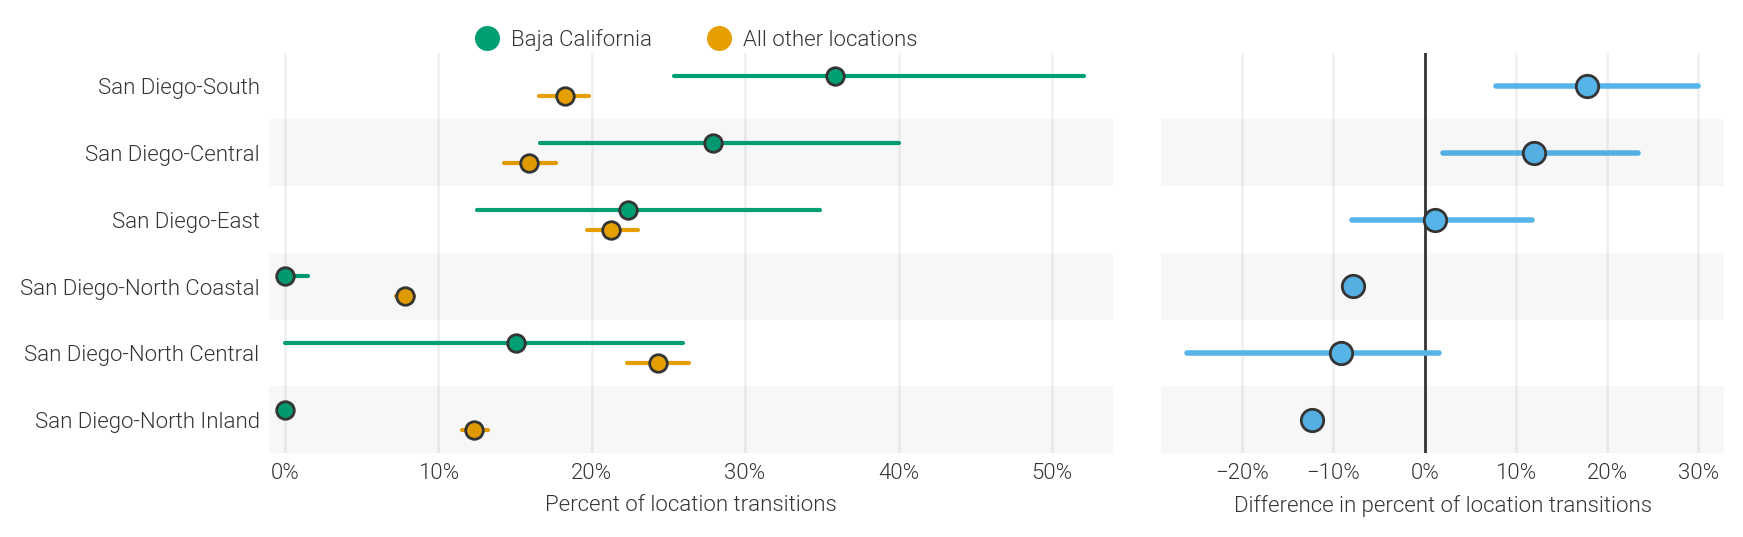

In [5]:
def plot_proportions( ax, df ):
    ax.scatter( df["median_rest"], df.index-0.15, s=40, color="#E69F00", zorder=5, edgecolor=COLOR, linewidths=1 )
    ax.scatter( df["median_bc"], df.index+0.15, s=40, color="#009E73", zorder=5, edgecolor=COLOR, linewidths=1 )
    ln = ax.hlines( df.index-0.15, xmin=df["quantile5_rest"], xmax=df["quantil95_rest"], color="#E69F00", zorder=4 )
    ln.set_capstyle( "round" )
    ln = ax.hlines( df.index+0.15, xmin=df["quantile5_bc"], xmax=df["quantil95_bc"], color="#009E73", zorder=4 )
    ln.set_capstyle( "round" )

    ax.set_yticks( df.index )
    ax.set_yticklabels( df["endLocation"] )
    basic_formatting( ax, spines=[], which="x", xlabel="Percent of location transitions", xlims=(-0.01, 0.54), ylims=(-0.5, 5.5), ysize=8, xsize=8 )

    ax.xaxis.set_major_formatter( PercentFormatter( 1, decimals=0 ) )
    ax.tick_params( axis="x", which="both", rotation=0, pad=0 )

    for i in range( 0, len( df.index ), 2):
        ax.axhspan( i-0.5,i+0.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0, zorder=5 )

    legend = [Line2D([0], [0], linestyle='none', marker='o', color="#009E73", label="Baja California", markersize=8 ),
              Line2D([0], [0], linestyle='none', marker='o', color="#E69F00", label="All other locations", markersize=8 )]
    ax.legend( loc="upper center", handletextpad=0.1, handles=legend, frameon=False, fontsize=8, ncol=2,
              bbox_to_anchor=(0,0,1.00,1.11) )

def plot_difference( ax, df ):
    ax.scatter( df["median"],prob.index, s=65, color="#56B4E9", zorder=5, edgecolor=COLOR, linewidths=1 )
    ln = ax.hlines( df.index, xmin=df["quantile5"], xmax=df["quantil95"], color="#56B4E9", linewidth=2, zorder=4 )
    ln.set_capstyle( "round" )

    ax.axvline( 0, color=COLOR, linewidth=1, zorder=2 )

    ax.set_yticks( df.index )
    ax.set_yticklabels( df["endLocation"] )
    basic_formatting( ax, spines=[], which="x", xlabel="Difference in percent of location transitions", ylims=(-0.5, 5.5), ysize=8, xsize=8 )

    ax.xaxis.set_major_formatter( PercentFormatter( 1, decimals=0 ) )
    ax.tick_params( axis="x", which="both", rotation=0, pad=0 )

    for i in range( 0, len( df.index ), 2):
        ax.axhspan( i-0.5,i+0.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0, zorder=5 )

fig, axis = plt.subplots( dpi=200, figsize=(9,3), ncols=2, sharey=True, gridspec_kw={"width_ratios" :(0.6, 0.4)} )
plot_proportions( axis[0], plot_df )
plot_difference( axis[1], prob )
axis[1].label_outer()
plt.tight_layout()
plt.savefig( "../analyses/plots/figure3_cross-border-introductions-destination.pdf" )
plt.show()

# Los Angeles vs. Baja California

We perform the same analysis, though only considering jumps from Baja California and Los Angeles.

In [20]:
# Baja California
jbc = jumps.loc[(jumps["startLocation"]=="Baja California")&(jumps["endLocation"].str.startswith( "San Diego"))]
plot_bc = jbc.pivot_table( index="treeId", columns="endLocation", values="time", aggfunc="count", fill_value=0 )
plot_bc = plot_bc.apply( lambda x: x/x.sum(), axis=1 )
plot_bc = plot_bc.agg( ["median", lambda x: x.quantile( 0.025 ), lambda x: x.quantile( 0.975)] ).T
plot_bc.columns = ["median", "quantile5", "quantil95"]

# All other locations
jrest = jumps.loc[(jumps["startLocation"]=="Los Angeles")&(jumps["endLocation"].str.startswith( "San Diego"))]
plot_rest = jrest.pivot_table( index="treeId", columns="endLocation", values="time", aggfunc="count", fill_value=0 )
plot_rest = plot_rest.apply( lambda x: x/x.sum(), axis=1 )
plot_rest = plot_rest.agg( ["median", lambda x: x.quantile( 0.025 ), lambda x: x.quantile( 0.975)] ).T
plot_rest.columns = ["median", "quantile5", "quantil95"]

# Combine the two locations while renaming the columns to reflect the source
plot_df = plot_rest.merge( plot_bc, left_index=True, right_index=True, suffixes=("_la", "_bc") )
plot_df["diff"] = plot_df["median_bc"] - plot_df["median_la"]
plot_df = plot_df.sort_values( "diff" ).reset_index()
plot_df

,endLocation,median_la,quantile5_la,quantil95_la,median_bc,quantile5_bc,quantil95_bc,diff
0,San Diego-North Inland,0.128878,0.117257,0.150538,0.000000,0.000000,0.000000,-0.128878
1,San Diego-North Central,0.232500,0.197861,0.261501,0.150943,0.000000,0.259259,-0.081557
2,San Diego-North Coastal,0.080831,0.065534,0.092697,0.000000,0.000000,0.015385,-0.080831
3,San Diego-East,0.216216,0.182022,0.240602,0.223881,0.125000,0.348837,0.007664
4,San Diego-Central,0.158654,0.129496,0.183908,0.279070,0.166667,0.400000,0.120416
5,San Diego-South,0.185446,0.158854,0.210826,0.358491,0.253968,0.520833,0.173045


In [21]:
jumps_collapse = jumps.copy()
jumps_sd = jumps_collapse.loc[jumps_collapse["endLocation"].str.startswith( "San Diego")]
jumps_sd = jumps_sd.loc[jumps_sd["startLocation"].isin(["Baja California","Los Angeles"])]
jumps_sd = jumps_sd.pivot_table( index="treeId", columns=["startLocation","endLocation"], values="time", aggfunc="count", fill_value=0 )
prob = jumps_sd["Baja California"].apply( lambda x: x/x.sum(), axis=1 ) - jumps_sd["Los Angeles"].apply( lambda x: x/x.sum(), axis=1 )
prob = prob.agg( ["median", lambda x: x.quantile( 0.05 ), lambda x: x.quantile( 0.95), lambda x: sum( x > 0 ) / len( x )] ).T
prob.columns = ["median", "quantile5", "quantil95", "prob"]
prob = prob.reindex( index=plot_df["endLocation"] ).reset_index()
prob

,endLocation,median,quantile5,quantil95,prob
0,San Diego-North Inland,-0.128878,-0.144847,-0.118162,0.000000
1,San Diego-North Central,-0.081777,-0.254011,0.028343,0.117157
2,San Diego-North Coastal,-0.080685,-0.090426,-0.065882,0.001110
3,San Diego-East,0.007425,-0.085467,0.117826,0.551360
4,San Diego-Central,0.121318,0.020338,0.236520,0.970572
5,San Diego-South,0.174543,0.071843,0.297426,0.996669


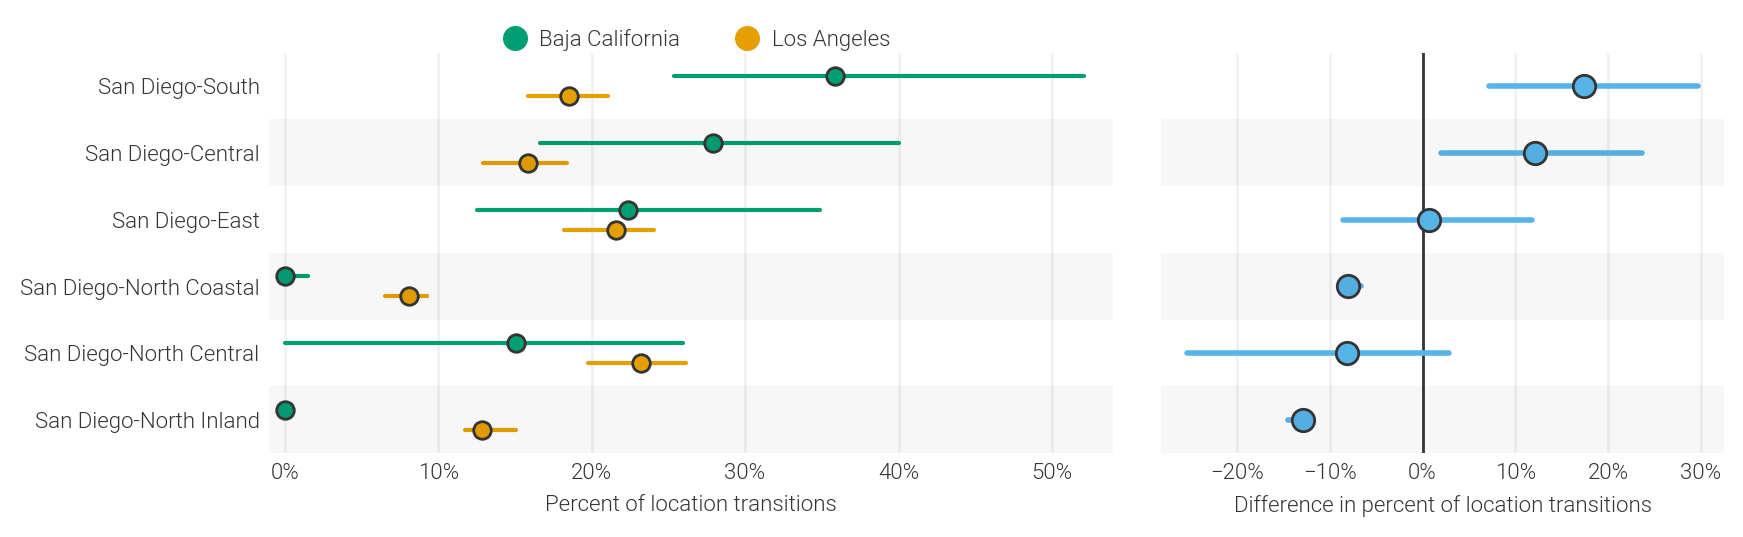

In [29]:
def plot_proportions( ax, df ):
    ax.scatter( df["median_la"], df.index-0.15, s=40, color="#E69F00", zorder=5, edgecolor=COLOR, linewidths=1 )
    ax.scatter( df["median_bc"], df.index+0.15, s=40, color="#009E73", zorder=5, edgecolor=COLOR, linewidths=1 )
    ln = ax.hlines( df.index-0.15, xmin=df["quantile5_la"], xmax=df["quantil95_la"], color="#E69F00", zorder=4 )
    ln.set_capstyle( "round" )
    ln = ax.hlines( df.index+0.15, xmin=df["quantile5_bc"], xmax=df["quantil95_bc"], color="#009E73", zorder=4 )
    ln.set_capstyle( "round" )

    ax.set_yticks( df.index )
    ax.set_yticklabels( df["endLocation"] )
    basic_formatting( ax, spines=[], which="x", xlabel="Percent of location transitions", xlims=(-0.01, 0.54), ylims=(-0.5, 5.5), ysize=8, xsize=8 )

    ax.xaxis.set_major_formatter( PercentFormatter( 1, decimals=0 ) )
    ax.tick_params( axis="x", which="both", rotation=0, pad=0 )

    for i in range( 0, len( df.index ), 2):
        ax.axhspan( i-0.5,i+0.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0, zorder=5 )

    legend = [Line2D([0], [0], linestyle='none', marker='o', color="#009E73", label="Baja California", markersize=8 ),
              Line2D([0], [0], linestyle='none', marker='o', color="#E69F00", label="Los Angeles", markersize=8 )]
    ax.legend( loc="upper center", handletextpad=0.1, handles=legend, frameon=False, fontsize=8, ncol=2,
              bbox_to_anchor=(0,0,1.00,1.11) )

def plot_difference( ax, df ):
    ax.scatter( df["median"],prob.index, s=65, color="#56B4E9", zorder=5, edgecolor=COLOR, linewidths=1 )
    ln = ax.hlines( df.index, xmin=df["quantile5"], xmax=df["quantil95"], color="#56B4E9", linewidth=2, zorder=4 )
    ln.set_capstyle( "round" )

    ax.axvline( 0, color=COLOR, linewidth=1, zorder=2 )

    ax.set_yticks( df.index )
    ax.set_yticklabels( df["endLocation"] )
    basic_formatting( ax, spines=[], which="x", xlabel="Difference in percent of location transitions", ylims=(-0.5, 5.5), ysize=8, xsize=8 )

    ax.xaxis.set_major_formatter( PercentFormatter( 1, decimals=0 ) )
    ax.tick_params( axis="x", which="both", rotation=0, pad=0 )

    for i in range( 0, len( df.index ), 2):
        ax.axhspan( i-0.5,i+0.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0, zorder=5 )

fig, axis = plt.subplots( dpi=200, figsize=(9,3), ncols=2, sharey=True, gridspec_kw={"width_ratios" :(0.6, 0.4)} )
plot_proportions( axis[0], plot_df )
plot_difference( axis[1], prob )
axis[1].label_outer()
plt.tight_layout()
fig.savefig( "../analyses/plots/figure3_cross-border-introductions-destination-la.pdf" )
fig.savefig( "../analyses/plots/figure3_cross-border-introductions-destination-la.png" )
plt.show()

# USA vs. Baja California
We perform the same analysis, though only considering jumps from Baja California and United States. This analysis probably won't be included because there are quite few jumps between US -> SD in the HHSA run. 

In [10]:
# Baja California
jbc = jumps.loc[(jumps["startLocation"]=="Baja California")&(jumps["endLocation"].str.startswith( "San Diego"))]
plot_bc = jbc.pivot_table( index="treeId", columns="endLocation", values="time", aggfunc="count", fill_value=0 )
plot_bc = plot_bc.apply( lambda x: x/x.sum(), axis=1 )
plot_bc = plot_bc.agg( ["median", lambda x: x.quantile( 0.025 ), lambda x: x.quantile( 0.975)] ).T
plot_bc.columns = ["median", "quantile5", "quantil95"]

# All other locations
jrest = jumps.loc[(jumps["startLocation"]=="United States")&(jumps["endLocation"].str.startswith( "San Diego"))]
plot_rest = jrest.pivot_table( index="treeId", columns="endLocation", values="time", aggfunc="count", fill_value=0 )
plot_rest = plot_rest.apply( lambda x: x/x.sum(), axis=1 )
plot_rest = plot_rest.agg( ["median", lambda x: x.quantile( 0.025 ), lambda x: x.quantile( 0.975)] ).T
plot_rest.columns = ["median", "quantile5", "quantil95"]

# Combine the two locations while renaming the columns to reflect the source
plot_df = plot_rest.merge( plot_bc, left_index=True, right_index=True, suffixes=("_us", "_bc") )
plot_df["diff"] = plot_df["median_bc"] - plot_df["median_us"]
plot_df = plot_df.sort_values( "diff" ).reset_index()
plot_df

,endLocation,median_us,quantile5_us,quantil95_us,median_bc,quantile5_bc,quantil95_bc,diff
0,San Diego-North Central,0.384615,0.0,1.0,0.150943,0.000000,0.259259,-0.233672
1,San Diego-North Coastal,0.000000,0.0,1.0,0.000000,0.000000,0.015385,0.000000
2,San Diego-North Inland,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,San Diego-East,0.000000,0.0,1.0,0.223881,0.125000,0.348837,0.223881
4,San Diego-Central,0.000000,0.0,1.0,0.279070,0.166667,0.400000,0.279070
5,San Diego-South,0.000000,0.0,1.0,0.358491,0.253968,0.520833,0.358491


In [15]:
jumps_collapse = jumps.copy()
jumps_sd = jumps_collapse.loc[jumps_collapse["endLocation"].str.startswith( "San Diego")]
jumps_sd = jumps_sd.loc[jumps_sd["startLocation"].isin(["Baja California","United States"])]
jumps_sd = jumps_sd.pivot_table( index="treeId", columns=["startLocation","endLocation"], values="time", aggfunc="count", fill_value=0 )
prob = jumps_sd["Baja California"].apply( lambda x: x/x.sum(), axis=1 ) - jumps_sd["United States"].apply( lambda x: x/x.sum(), axis=1 )
prob = prob.agg( ["median", lambda x: x.quantile( 0.05 ), lambda x: x.quantile( 0.95), lambda x: sum( x > 0 ) / len( x )] ).T
prob.columns = ["median", "quantile5", "quantil95", "prob"]
prob = prob.reindex( index=plot_df["endLocation"] ).reset_index()
prob

,endLocation,median,quantile5,quantil95,prob
0,San Diego-North Central,-0.249604,-0.928409,0.203390,0.164908
1,San Diego-North Coastal,0.000000,-0.410985,0.000000,0.021099
2,San Diego-North Inland,0.000000,0.000000,0.000000,0.012215
3,San Diego-East,0.173077,-0.648144,0.300000,0.485286
4,San Diego-Central,0.213333,-0.677504,0.366057,0.520267
5,San Diego-South,0.318182,-0.281237,0.457440,0.644087


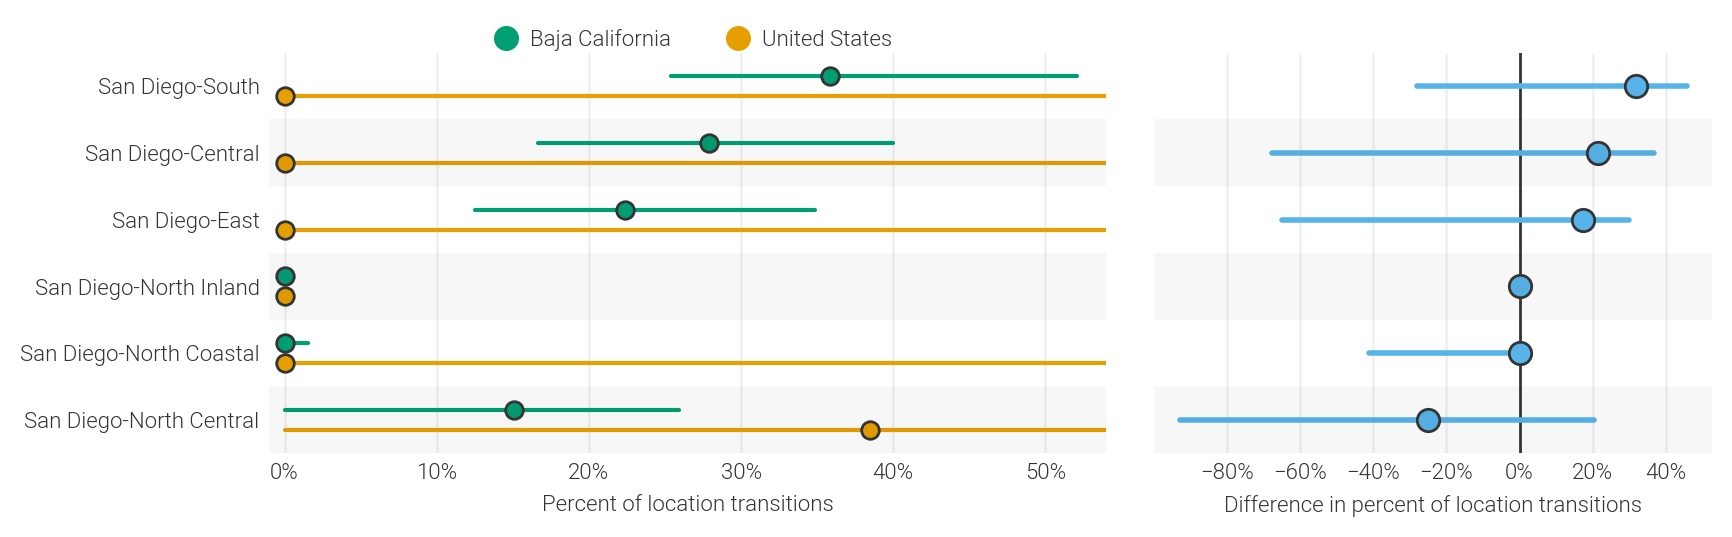

In [16]:
def plot_proportions( ax, df ):
    ax.scatter( df["median_us"], df.index-0.15, s=40, color="#E69F00", zorder=5, edgecolor=COLOR, linewidths=1 )
    ax.scatter( df["median_bc"], df.index+0.15, s=40, color="#009E73", zorder=5, edgecolor=COLOR, linewidths=1 )
    ln = ax.hlines( df.index-0.15, xmin=df["quantile5_us"], xmax=df["quantil95_us"], color="#E69F00", zorder=4 )
    ln.set_capstyle( "round" )
    ln = ax.hlines( df.index+0.15, xmin=df["quantile5_bc"], xmax=df["quantil95_bc"], color="#009E73", zorder=4 )
    ln.set_capstyle( "round" )

    ax.set_yticks( df.index )
    ax.set_yticklabels( df["endLocation"] )
    basic_formatting( ax, spines=[], which="x", xlabel="Percent of location transitions", xlims=(-0.01, 0.54), ylims=(-0.5, 5.5), ysize=8, xsize=8 )

    ax.xaxis.set_major_formatter( PercentFormatter( 1, decimals=0 ) )
    ax.tick_params( axis="x", which="both", rotation=0, pad=0 )

    for i in range( 0, len( df.index ), 2):
        ax.axhspan( i-0.5,i+0.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0, zorder=5 )

    legend = [Line2D([0], [0], linestyle='none', marker='o', color="#009E73", label="Baja California", markersize=8 ),
              Line2D([0], [0], linestyle='none', marker='o', color="#E69F00", label="United States", markersize=8 )]
    ax.legend( loc="upper center", handletextpad=0.1, handles=legend, frameon=False, fontsize=8, ncol=2,
              bbox_to_anchor=(0,0,1.00,1.11) )

def plot_difference( ax, df ):
    ax.scatter( df["median"],prob.index, s=65, color="#56B4E9", zorder=5, edgecolor=COLOR, linewidths=1 )
    ln = ax.hlines( df.index, xmin=df["quantile5"], xmax=df["quantil95"], color="#56B4E9", linewidth=2, zorder=4 )
    ln.set_capstyle( "round" )

    ax.axvline( 0, color=COLOR, linewidth=1, zorder=2 )

    ax.set_yticks( df.index )
    ax.set_yticklabels( df["endLocation"] )
    basic_formatting( ax, spines=[], which="x", xlabel="Difference in percent of location transitions", ylims=(-0.5, 5.5), ysize=8, xsize=8 )

    ax.xaxis.set_major_formatter( PercentFormatter( 1, decimals=0 ) )
    ax.tick_params( axis="x", which="both", rotation=0, pad=0 )

    for i in range( 0, len( df.index ), 2):
        ax.axhspan( i-0.5,i+0.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0, zorder=5 )

fig, axis = plt.subplots( dpi=200, figsize=(9,3), ncols=2, sharey=True, gridspec_kw={"width_ratios" :(0.6, 0.4)} )
plot_proportions( axis[0], plot_df )
plot_difference( axis[1], prob )
axis[1].label_outer()
plt.tight_layout()
#plt.savefig( "../analyses/plots/figure3_cross-border-introductions-destination-la.pdf" )
plt.show()